# PHYS20762 - Project 1 - Measuring Drop Spreading Law
# The Damped Harmonic Oscillator

Divij Gupta (ID: 10628702)
University of Manchester
April 2022

First we need to initialise the Python interpreter

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Introduction

This report looks to numerically analyse a spring mass system subjected to an external force, ${F}(t)$, which can be written by the differential equation: $$ m \ddot{x}(t) + b \dot{x}(t) + kx(t) = {F}(t) $$ where $m$ is the mass, $b$ is the damping constant, $k$ is the spring constant and ${x}(t)$, $\dot{x}(t)$, $\ddot{x}(t)$ are the position, velocity and acceleration respectively. The value of $m$ and $k$ will be specified and fixed throughout while $b$ and ${F}(t)$ are varied to investigate the nature of the solution which is further discussed later.

Before attempting to solve the forced equation, we will first investigate a simpler case with ${F}(t) = 0$ so that our numerical methods can be compared to an analytical solution and the best one determined by comparison. The numerical methods considered here are the Euler, Improved Euler, Euler-Cromer and Verlet methods each of which are explored in detail.

We start by setting some initial parameters

In [2]:
# Setting the fixed physical parameters
k = 2.63  # Spring constant in kg/s^2
m = 3.7  # Mass in kg

# Setting fixed runtime conditions
T = 150  # The total runtime in s

# Setting the initial conditions
x_0 = 0  # The initial position in m
v_0 = -1  # The initial velocity in m/s

# Setting the plot specifics
plt.rcParams.update({'font.size': 12})
plt.style.use('default')

## Numerical methods

We will first code each method as functions to return the position and velocity data at each time-step using the parameters defined above.

All the Euler methods (Euler, Improved Euler and Euler-Cromer) are known as 'forward methods' as they use the values at some step $i$ to calculate the values at some later step $i + 1$. Verlet's method on the other hand is an implicit method as it requires step $i - 1$ to be known as well which means it is not self-starting, consequences of this are discussed later.

We start with the Euler method. Since $h$ is small, to look at the position at some time $t + h$ relative to time $t$, we can use a Taylor expansion: $$ {x}(t+h) = x(t) + h \dot{x}(t) + error $$ We can also look at the velocity in the same way with its own taylor expansion. The error on the position can be seen to be of order $h^2$ from the expansion above and the error on the velocity can be found to be of order $h$ from comparison of the ${x}(t)$ taylor expansion to the derivative of position with time from first principles.

Euler's method uses the first 2 terms in each expansion to give the values of $x$ and $v$ at time-step $i + 1$ as: $$ x_{i+1} = x_{i} + hv_{i} $$ $$ v_{i+1} = v_{i} + ha_{i} $$ where $a_{i}$ is given from the rearranged original differential equation as: $$a_{i} = -\frac{k}{m}x_{i} - \frac{b}{m}v_{i}$$

In [3]:
def euler(n_steps, h, b):  # Should the empty arrays and initial values input be global
    # Creating empty arrays for the x and v values
    x = np.zeros(n_steps)
    v = np.zeros(n_steps)

    # Putting in the initial values
    x[0] = x_0
    v[0] = v_0

    for i in range(n_steps - 1):  # -1 for as python counts from 0 not 1
        # Calculating the acceleration at step i (in m/s^2)
        a = - (k / m) * x[i] - (b / m) * v[i]
        # For each configuration at step i, calculating x (in m) and v (in m/s) for the later step i+1
        x[i+1] = x[i] + v[i] * h
        v[i+1] = v[i] + a * h

    return x, v

Next is the Improved Euler method. This is largely the same as above but this time we include another term in the taylor expansion of ${x}(t)$ since we know $\ddot{x}(t)$ as the acceleration. This serves to improve accuracy and reduces the error by one order or magnitude so the errors on $x$ and $v$ are now of order $h^3$ and $h^2$ respectively.

Our iterative process now reads as: $$x_{i+1} = x_{i} + hv_{i} + \frac{1}{2}h^2a_{i}$$ with $v_{i+1}$ and $a_{i}$ being the same as they were for the Euler method above.

In [4]:
def improved_euler(n_steps, h, b):
    # Same methodology as euler() with just the x_i+1 term changing

    x = np.zeros(n_steps)
    v = np.zeros(n_steps)
    x[0] = x_0
    v[0] = v_0

    for i in range(n_steps - 1):
        a = - (k / m) * x[i] - (b / m) * v[i]
        x[i+1] = x[i] + v[i] * h + 1/2 * h**2 * a  # This is where the extra term is added from the Taylor expansion
        v[i+1] = v[i] + a * h

    return x, v

Following this we have the last of the forward methods, the Euler-Cromer method. This is again largely the same as the Euler method but this time in the expression for $x_{i+1}$, we include $v_{i+1}$ instead of $v_{i}$: $$x_{i+1} = x_{i} + hv_{i+1}$$ where the errors on $x$ and $v$ are the same as for the Euler method, they are of order $h^2$ and $h$ respectively.

We will look at the consequence of this in more detail later when we talk about energies but in short this ensures conservation of energy making the method symplectic.

In [5]:
def euler_cromer(n_steps, h, b):
    # Same methodology as euler() with just the x_i+1 term changing

    x = np.zeros(n_steps)
    v = np.zeros(n_steps)
    x[0] = x_0
    v[0] = v_0

    for i in range(n_steps - 1):
        a = - (k / m) * x[i] - (b / m) * v[i]
        v[i+1] = v[i] + a * h
        x[i+1] = x[i] + v[i+1] * h  # This is where the extra term is added to make the method symplectic

    return x, v

The final method is the implicit Verlet's method. This uses a different approach by looking at the taylor expansions of $x_{i+1}$ and $x_{i-1}$ and rearranging and combining them to compare them to a centred derivative. For velocity, this centred derivative is of the form: $$\dot{x}(t) = \frac{x(t+h)-x(t-h)}{2h} + error$$

Using as many terms as possible in the Taylor expansion (as many terms as we know the values for), the values of $x$ and $v$ at step $i+1$ care given as: $$x_{i+1} = 2x_{i} - x_{i-1} + h^2a_{i}$$ $$v_{i} = \frac{x_{i+1}-x_{i-1}}{2h}$$ where $a$ is the same as in all the other methods and the errors on $x$ and $v$ are of order $h^4$ and $h^2$ respectively.

Since $v$ has no dependence on $a$ but does depend on $x_{i+1}$, to actually solve these series of equations we have to combine the $x_{i+1}$ and $a$ expressions substituting $v_{i}$, and rearrange to give:
$$ x_{i+1} = \frac{2(2m - kh^2)}{2m + bh} x_{i} + \frac{bh - 2m}{2m + bh} x_{i-1}$$

As mentioned previously, this method is not self-starting as we require information about step $i-1$ to begin. To circumvent this, I have chosen to use the Improved Euler method to perform the first step as the error on the position is of similar order, $h^3$, or rather as close as possible to $h^4$.

In [6]:
def verlet(n_steps, h, b):
    # Same initial setup as always
    x = np.zeros(n_steps)
    v = np.zeros(n_steps)
    x[0] = x_0
    v[0] = v_0

    # Using the improved Euler method function to get the first 2 values for x (hence using n_steps = 2)
    x_temp, v_temp = improved_euler(2, h, b)
    x[1] = x_temp[1]

    # Defining some temporary constants to make the subsequent x_i+1 calculation easier
    const_d = 2 * m + b * h
    const_a = (2 / const_d) * (2 * m - k * h**2)
    const_b = (1 / const_d) * (b * h - 2 * m)

    for i in range(1, n_steps - 1):
        # Using the numerical method above to find the values at step i
        x[i+1] = const_a * x[i] + const_b * x[i-1]
        v[i] = (1 / (2 * h)) * (x[i+1] - x[i-1])
        # Important to note that v will not have a term at t = T as that would require an x value at t > Ts

    return x, v

## Comparison to the Analytical solution

To find out which is the best method to use, we can explore the analytical solution for this non-forced differential equation given by: $$ m \ddot{x}(t) + b \dot{x}(t) + kx(t) = 0 $$ and compare it to each aforementioned method.

From this we can see that the system can be in one of 3 states depending on the choice of $b$: $4km - b^2 > 0$ gives under-damping, $4km - b^2 < 0$ gives over-damping and $4km - b^2 = 0$ gives critical damping where the system comes to rest in the shortest period of time. This means the critical value can be given as: $$b_{crit} = 2 \sqrt{km}$$ and the analytical solution has two different forms depending on if $b$ is or is not equal to $b_{crit}$.

For $b \neq b_{crit}$ we have: $$ {x}(t) = e^{\frac{-\gamma t}{2}}(Ae^{i\omega t} + Be^{-i \omega t}) $$ and for $b = b_{crit}$ we have: $$ {x}(t) = (A + Bt)e^{\frac{-\gamma t}{2}} $$ where in both cases $\omega$ is the angular frequency  given by: $$ \omega^2 = \omega_{0}^2 - \frac{\gamma^2}{4}, $$ $\omega_{0}$ is the natural angular frequency given by: $$ \omega_{0} = \sqrt{\frac{k}{m}} ,$$ and $\gamma$ is the damping ratio given by: $$ \gamma = \frac{b}{m} .$$

$A$ and $B$ are constants fixed by initial conditions and so for a known ${x}(0) = x_{0}$ and ${v}(0) = v_{0}$ are given by: $$ B = \frac{1}{2}(\frac{i}{\omega}v_{0} + (\frac{i\gamma}{2\omega} + 1)x_{0}) $$ $$A = x_{0} - B.$$

To find the corresponding velocities, in each case the analytical solution can be differentiated with respect to time.

In [7]:
# Defining the natural frequency as a global constant
omega_0 = np.sqrt(k / m)

# Printing the critical value for b
b_crit = 2 * np.sqrt(k * m)
print(f"For m = {m} kg and k = {k} kg/s^2, the critical value for the damping constant is given by b = {b_crit:.2f} kg/s")

For m = 3.7 kg and k = 2.63 kg/s^2, the critical value for the damping constant is given by b = 6.24 kg/s


In [8]:
def analytical(t, b):
    # Calculates the analytical solution to take and return values for all time-steps so that it stays consistent with the numerical method functions

    # Defining some useful constants based on the equations written above
    gamma = b / m
    omega = np.sqrt(omega_0**2 - gamma**2 / 4)

    # Finding the constants based on the initial conditions
    B = 1/2 * (1j * v_0 / omega + (1j * gamma / (2 * omega) + 1) * x_0)
    A = x_0 - B

    factor = np.exp(- gamma * t / 2)  # Helps keep the algebra below cleaner
    # Find the current displacement and velocity according to the current value of b based on the equations above
    if b == b_crit:
        x = (A + B * t) * factor
        v = factor * (B * (1 - gamma / 2) - A * gamma / 2)

    else:
        power = 1j * omega * t  # Helps keep the algebra below cleaner
        x = factor * (A * np.exp(power) + B * np.exp(-power))
        v = factor * (A * np.exp(power) * (1j * omega - gamma / 2) - B * np.exp(-power) *
                           (1j * omega + gamma / 2))

        # Converts x and v to physical real quantities
        x = np.real(x)
        v = np.real(v)

    return x, v

# Allows the function to have an array input so that it returns an array as well
analytical = np.vectorize(analytical)

For now, to compare the numerical integration methods, it is best to consider an under damped system so we will take $b << b_{crit}$. The value for $h$ will be the one assigned right at the beginning and is such to show some differences in the different methods.

There will be 2 plots for each method, one will be of displacement against time to show how the system oscillates around equilibrium and the other will be of displacement against velocity as another representation of the oscillation in terms of a phase space plot. Both can be used to see if the system shows the correct physical behaviour and how that numerical method differs from the analytical solution. The phase space plot also makes it easier to visually see differences between numerical and analytical solutions further justifying its inclusion here.

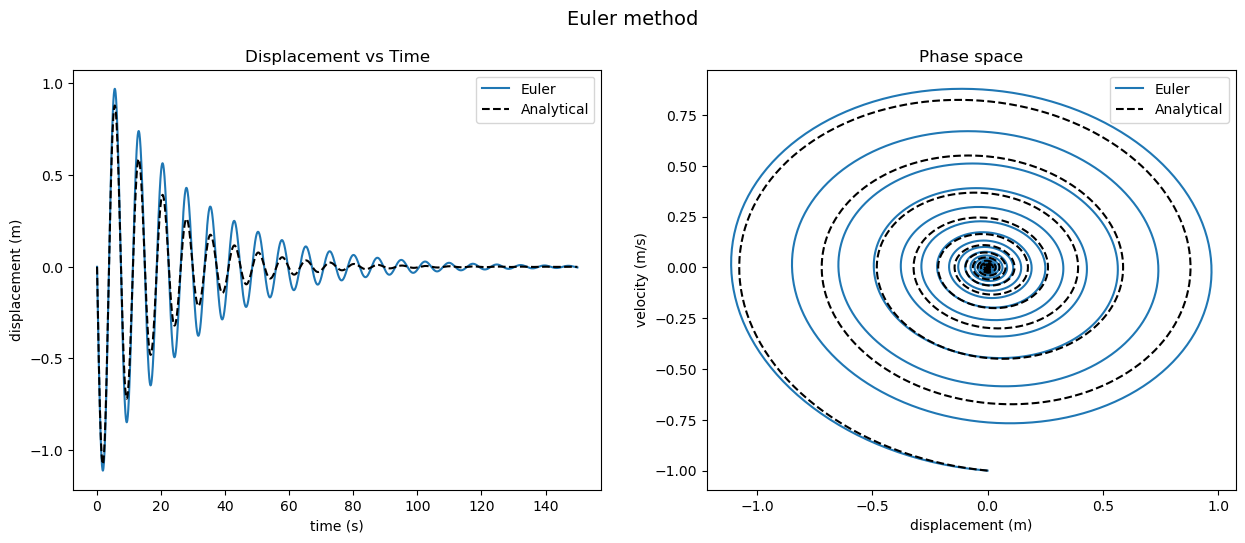

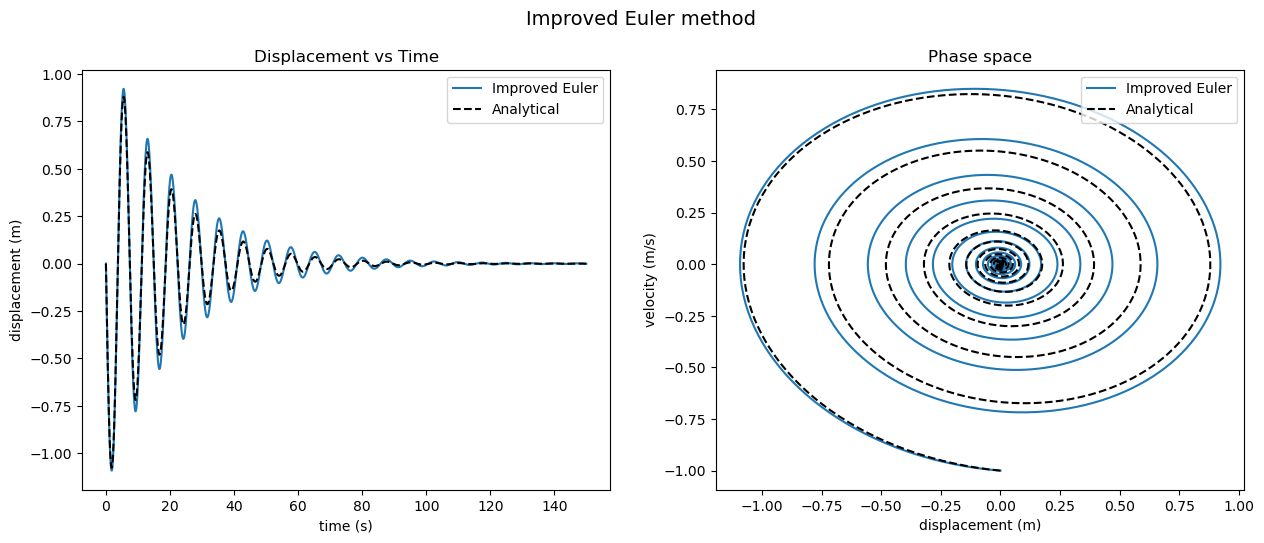

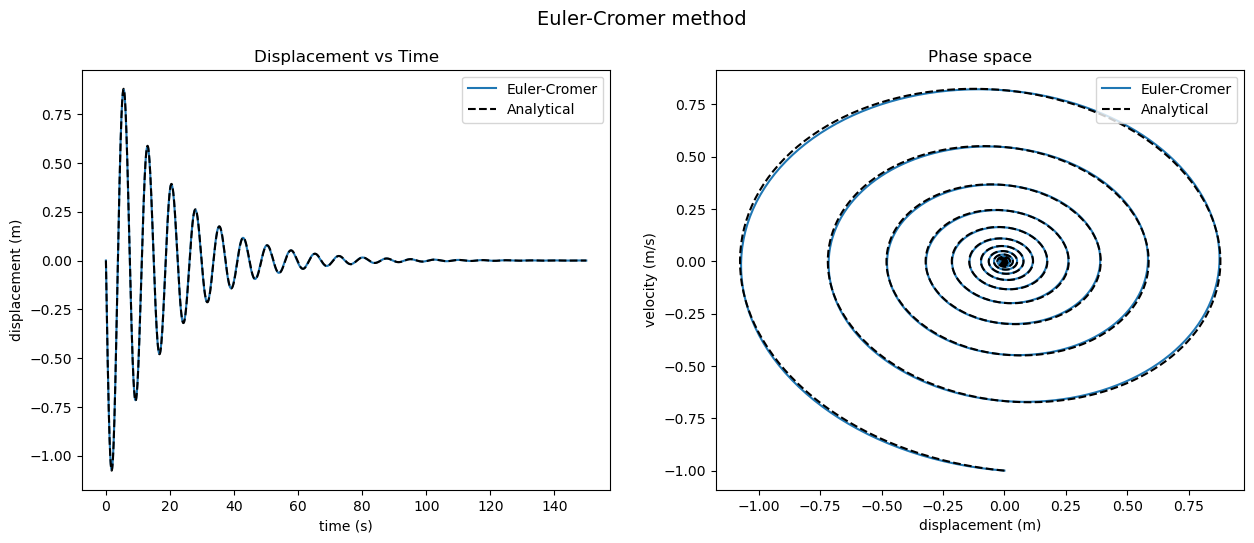

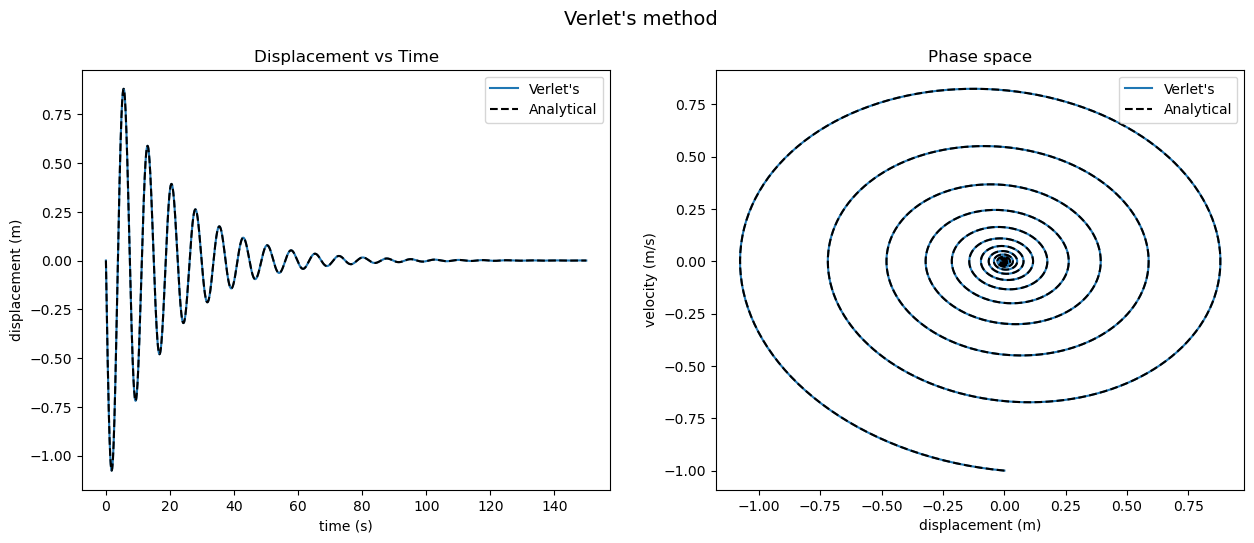

In [9]:
# Defining a function that compares a given method to another method (written specifically to be the analytical solution but an in theory be any other method) and plots 2 graphs as detailed in the section above
def comparison_plot(method_name, times, x_test, v_test, x_true=None, v_true=None, extra_title='', phase_plot=True):

    # Only displays the analytical solution if the corresponding x and v are provided
    if x_true is None or v_true is None:
        analytic = False
    else:
        analytic = True

    # Tweaks the figure and labels depending on if a phase plot is added or not
    if phase_plot:
        figure_size = (15, 12)
        figure_sup_title = f'{method_name} method ' + extra_title
        plot_title = f"Displacement vs Time"
    else:
        figure_size = (12, 10)
        figure_sup_title = None
        plot_title = f"Displacement vs Time - {method_name} " + extra_title

    # Initialising the figure and subplots
    fig = plt.figure(figsize=figure_size)
    fig.suptitle(figure_sup_title, fontsize=14, y=0.93)

    # Plots the displacement vs time graph for the given method and the analytical solution if requested
    ax1 = fig.add_subplot(221)
    ax1.plot(times, x_test, label=method_name)
    if analytic:
        ax1.plot(times, x_true, 'k--', label='Analytical')
    ax1.set_xlabel("time (s)")
    ax1.set_ylabel("displacement (m)")
    ax1.set_title(plot_title)
    ax1.legend(loc='upper right', fontsize=10)

    if phase_plot:
        # Uses 'in' not '==' so accommodate a potential verlet_forced method/function later on
        if "Verlet's" in method:
            # For Verlet's method, there is no final velocity value (it is by default set to zero) so to avoid any complications, we do not plot it at all. This must change x as well so that the arrays remain of the same size.
            x_test, v_test = x_test[:-1], v_test[:-1]
            if analytic:
                x_true, v_true = x_true[:-1], v_true[:-1]

        # Plots the phase space plot for the given method and the analytical solution if requested
        ax2 = fig.add_subplot(222)
        ax2.plot(x_test, v_test, label=method_name)
        if analytic:
            ax2.plot(x_true, v_true, 'k--', label='Analytical')
        ax2.set_xlabel("displacement (m)")
        ax2.set_ylabel("velocity (m/s)")
        ax2.set_title(f"Phase space")
        ax2.legend(loc='upper right', fontsize=10)

    # Displays the 2 plots
    plt.show()

# Defining a function to find one useful quantities that always come up when h is changed
def useful_conditions(h, total_time=T):
    n_steps = int(total_time / h)  # The number of steps in the iterative numerical integration
    times = [i * h for i in range(n_steps)]  # Converting the steps into times to plot

    return n_steps, times

# Defining some runtime conditions
h_initial = 0.05  # The time-step in s
b_initial = 0.4  # The damping constant in kg/s
n_steps_initial, times_initial = useful_conditions(h_initial)

# Putting the various methods that need testing and their respective functions into a dictionary
numerical_methods = {'Euler': euler,
                     'Improved Euler': improved_euler,
                     'Euler-Cromer': euler_cromer,
                     "Verlet's": verlet,
                     }

# Finding values for x and v based on the analytical solution
x_analytic_initial, v_analytic_initial = analytical(times_initial, b_initial)
# Chosen to keep this outside the function so that it isn't recalculated every time the program is run - reduces computational time

# Plots the figures for each of the 4 different methods on by one
for method, function in numerical_methods.items():
    # Finding x and v for that specific numerical method to compare with the analytical solution
    x_numerical, v_numerical = function(n_steps_initial, h_initial, b_initial)
    comparison_plot(method, times_initial, x_numerical, v_numerical, x_analytic_initial, v_analytic_initial)

From this, we can see that all the plots demonstrate the correct behaviour, showing the osillations damping to zero displacement and an attractor at the origin of the phase space plot. However, the Euler and Improved Euler methods do not represent the system very well when compared to the analytical solution with the Euler method being the worst. Both the other 2 methods, Euler-Cromer and Verlet, seem much better and almost are almost identical with only the Euler-Cromer phase space plot seeming to be slightly elongated.

From this we could conclude that Verlet's method is marginally the most accurate but to definitively conclude anything, it is important to look at how these results change with a different choice of $h$. To motivate this discussion, we can look at 2 other choices of $h$ for the same value of $b$ and see how we get vastly different results to the ones above. We will use the Euler method as an example for this.

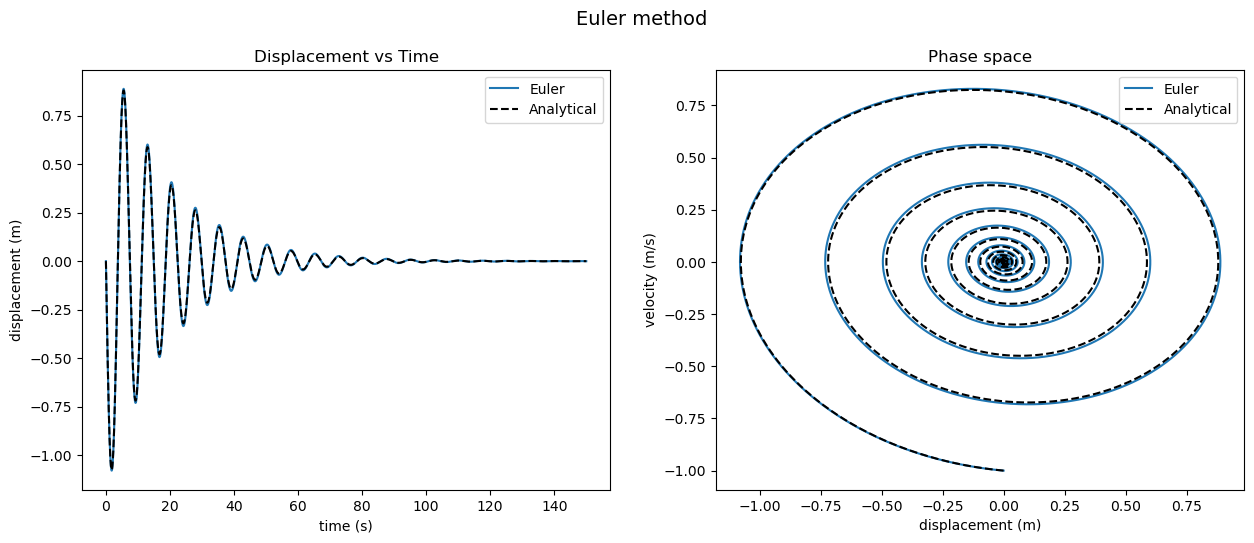

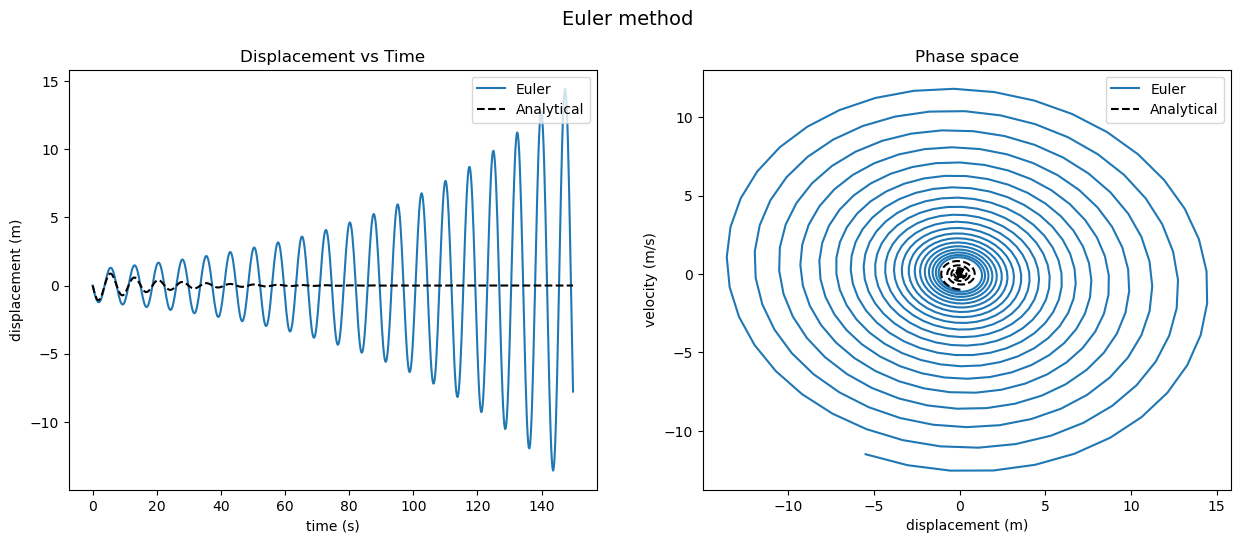

In [10]:
illustrative_h_values = [0.005, 0.2]  # h values chosen specifically to illustrate the point above

# Looping through the two values
for h_trial in illustrative_h_values:
    # Redefining the runtime conditions for the new h value
    n_steps_trial, time_trial = useful_conditions(h_trial)

    # Finding the analytical solution with these new conditions
    x_analytic_trial, v_analytic_trial = analytical(time_trial, b_initial)

    x_euler, v_euler = euler(n_steps_trial, h_trial, b_initial)

    # Calling the function to compare the Euler method with these new conditions to the analytical solution
    comparison_plot('Euler', time_trial, x_euler, v_euler, x_analytic_trial, v_analytic_trial)

If we had only seen the first plots here, we would have concluded that the Euler method is just as good as Verlet's but this is only the case because the step size is so small and the plot we had earlier shows this. Alternatively for a large step-size, as in the second plot, we get a very different picture. Now, although the system hasn't changed, there is no longer an attractor at the origin of the phase space plot and looking at the displacement, the oscillations have somehow increased in magnitude! This is why it is important to test all these methods for different values of $h$ to see which combination will be the best moving forward, bearing in mind longer computational times for smaller $h$, when we explore forced oscillations.

The increase in displacement shows there is energy being added to the system indicating that the Euler method does not conserve energy. This is an extention of what was stated before, the Euler-Cromer and Verlet's method are the only methods that conserve energy, the only symplectic methods.

## Energy and finding the best numerical method

Using the analytical solution, we can define the total energy associated with any given value of $x$ and $v$ (at any step $i$) as: $$E = \frac{1}{2}kx^2 + \frac{1}{2}mv^2$$ where the energy is given in Joules.

In [11]:
def find_energy(x, v):
    # Calculates and returns the energy as given by the equation above
    energy = 1/2 * k * x**2 + 1/2 * m * v**2

    return energy

For comparison simplicity if we take $b = 0$, we would expect a constant energy since there is no damping. However, using the equation above we can see that the Euler and Improved Euler methods actually increase in energy with each step, $E_{i+1} > E_{i}$, but the other two symplectic methods, while they may vary around this constant value, average out so that $E_{i+1} \approx E_{i}$ over one cycle.

We will do this by finding the percentage difference between each total energy from the numerical method currently being tested and the total energy according to the analytical solution for each value of $h$ for a fixed $b$. This is encompassed in the following expression: $$ E_{diff} = \frac{1}{n_{steps}}\sum_{i=0, t=0}^{n_{steps}, T}\frac{|E_{test} - E_{true}|}{E_{true}} $$ where $E_{test}$ is the energy at a step $i$ being summed to the total number of steps $n_{steps}$ and $E_{true}$ is the energy at time $t$ being summed to the total time $T$ defined at the very beginning. The absolute value is taken so we can easily compare this to a threshold of acceptance, set as 0.001, which is shown by the dashed line. We have chosen to sum over all differences instead of finding the difference of the sum to see how each subsequent value changes to give a better estimate on how accurate each method is overall.

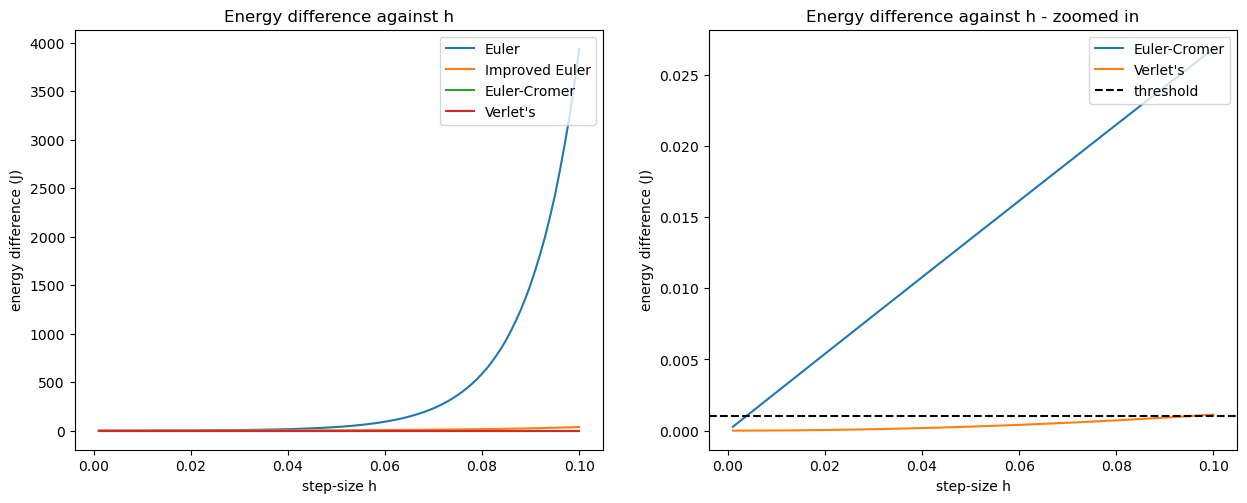

In [12]:
b_test = 0.1  # A value such that the oscillations don't die down to zero over the time period T ensuring we are not dividing my numbers near zero (where numerical errors will be large) when finding successive differences.

# Defining a function to find the energy difference between E_i and E_i+1
def find_energy_diff(h, b, method_information):

    # Finding the necessary conditions to run the methods
    n_steps, times = useful_conditions(h)

    # Finding the energy according to the analytical solution
    x_true, v_true = analytical(times, b)
    energy_true = find_energy(x_true, v_true)

    # Creating an empty list to store the energy diffs for each numerical method
    all_diffs = []

    # Looping through each method
    for method, function in method_information.items():
        # Finding the energy according to the numerical method
        x_test, v_test = function(n_steps, h, b)
        energy_test = find_energy(x_test, v_test)

        # # For Verlet's method, there is no final velocity value (it is by default set to zero) so to avoid any complications, we remove the final energy value in the energy_test array.
        if "Verlet's" in method:
            energy_test = energy_test[:-1]
            energy_true = energy_true[:-1]

        # Finding the sum of successive differences and adding them to the list (for a given h value)
        diff_each = np.abs(energy_test - energy_true) / energy_true
        diff = np.sum(diff_each) / n_steps
        all_diffs.append(diff)

    return all_diffs

# The reason every method is compared to the analytical for any given h value before trialing the next h value instead of looping through each method later is to save on computing time. This way the analytical solution is only calculated once for every h value instead of being calculated 4 times.

# Creating a list of h values to loop through
h_values = np.linspace(0.001, 0.1, num=100)

# Assigning the confidence limit
threshold_initial = 0.001

# Creating an empty dictionary
numerical_methods_energydiffs = {}

# Creating an empty array to store all the differences from all the methods (horizontally) for all values of h (vertically)
all_energy_diffs = np.empty((0, len(numerical_methods)))

# Looping through each h and finding each energy difference and adding them to the array
for h_value in h_values:
    all_energy_diffs_temp = find_energy_diff(h_value, b_test, numerical_methods)
    all_energy_diffs = np.vstack((all_energy_diffs, all_energy_diffs_temp))

# Stores all the information in 'all_energy_diffs' in a more accessible format to use and add to later and reduces computational time in not having to calculate these values again.
for index, method in enumerate(numerical_methods.keys()):
    energy_diffs = all_energy_diffs[:, index]
    numerical_methods_energydiffs[method] = energy_diffs

# Defining a function to plot energy differences when given a dictionary with that information
def energy_diff_plot(methods_energydiffs, threshold):

    # Creating the figure
    fig = plt.figure(figsize=(15, 12))

    # Adding a subplot to show all the results
    ax1 = fig.add_subplot(221)
    plot_title = 'Energy difference against h'

    # Adding another subplot to only show the 'useful' information near the confidence interval
    ax2 = fig.add_subplot(222)

    # Setting up everything for the 1st plot
    ax1.set_title(plot_title)
    ax1.set_xlabel('step-size h')
    ax1.set_ylabel('energy difference (J)')

    # Setting up everything for the 2nd plot
    ax2.set_title(plot_title + ' - zoomed in')
    ax2.set_xlabel('step-size h')
    ax2.set_ylabel('energy difference (J)')

    # Plotting the results for each method using the stored values from the dictionary
    for method, energy_diffs in methods_energydiffs.items():
        ax1.plot(h_values, energy_diffs, label=method)

        # Deciding if the values for each method are close enough to the confidence interval and plotting accordingly on second plot
        if np.max(energy_diffs) < threshold * 100:  # 100 arbitrarily chosen from trial and error
            ax2.plot(h_values, energy_diffs, label=method)

    # Adding the confidence interval
    ax2.axhline(threshold, color='k', linestyle='--', label='threshold')

    # Showing the legend and the plot
    ax1.legend(loc='upper right', fontsize=10)
    ax2.legend(loc='upper right', fontsize=10)
    plt.show()

# Calling the function to use it for the 4 methods discussed and the initial threshold value
energy_diff_plot(numerical_methods_energydiffs, threshold_initial)

From the graphs we can now definitively say that Verlet's method is the best for any value of h (above ones very close to zero where is ambiguous) and that Euler's method is by far the worst veering off drastically from the expected results after $h \approx 0.04$. This also confirms the theory that the Euler and Improved Euler methods are not symplectic as they have the largest energy differences while the Euler-Cromer and Verlet's method remain comparable.

Using this we can now find our optimal value for $h$ by selecting the highest value possible within our assigned confidence interval.



In [13]:
# Extracting all the energy diffs for Verlet's method
energy_diffs_verlet = numerical_methods_energydiffs["Verlet's"]

# Creating an empty list
good_energy_diffs_verlet = []

# Adding to the list if the energy diff is within the confidence interval
for energy_diff in energy_diffs_verlet:
    if energy_diff <= threshold_initial:
        good_energy_diffs_verlet.append(energy_diff)

# Finding the index of the largest value still within the interval
significant_diff_index = np.where(energy_diffs_verlet == np.max(good_energy_diffs_verlet))
significant_diff_index = significant_diff_index[0][0]

# Finding the h value corresponding this largest difference
h_final = h_values[significant_diff_index]
print(f"Best value for step-size: h = {h_final:.3f}.")


Best value for step-size: h = 0.094.


It is important to note that because of numerical errors associated with Python storing floating point numbers,  there will never be a 100% accurate method by design of the programme. This is another reason, apart from computational time, why we cannot choose an arbitrarily low value for $h$ since after a certain point, decreasing $h$ further would actually make the methods less accurate since each successive $x$ or $v$ calculation would be within the error limits of Python! Ultimately this is the reason for the inclusion of a confidence interval and taking the largest value of $h$ within this interval, it is a compromise between choosing the best $h$ value, choosing the best method $h$, lowering the accuracy as much as possible and keeping a reasonable computational time.

There are many other ways to compare the numerical methods not detailed here. For example one could plot residuals of the displacement or velocity directly instead and calculate a chi-squared for each value of $h$. These would follow the error schemes detailed earlier for each method (for instance, the displacement using Euler's method has an error of order $h^2$) and could be used in the same way as above to find the best value of $h$. Alternatively this could be used to implement a chi-squared minimisation routine which largely serves the same purpose albeit ignoring the discussion of numerical errors above. This would however only consider either $x$ or $v$ when it is better to consider both and would neglect the concerns regarding symplectic and non-symplectic integrators hence why we didn't use these methods here.

We can now use Verlet's method to look at different types of damping as discussed before when we looked at the analytical solution in detail. Using $b_{crit}$ as definied before, we will consider $b = \frac{1}{2} b_{crit}$ to be under-damping and $b = 2b_{crit}$ to be over-damping and plot the different results on one graph this time without the analytical solution to better compare them

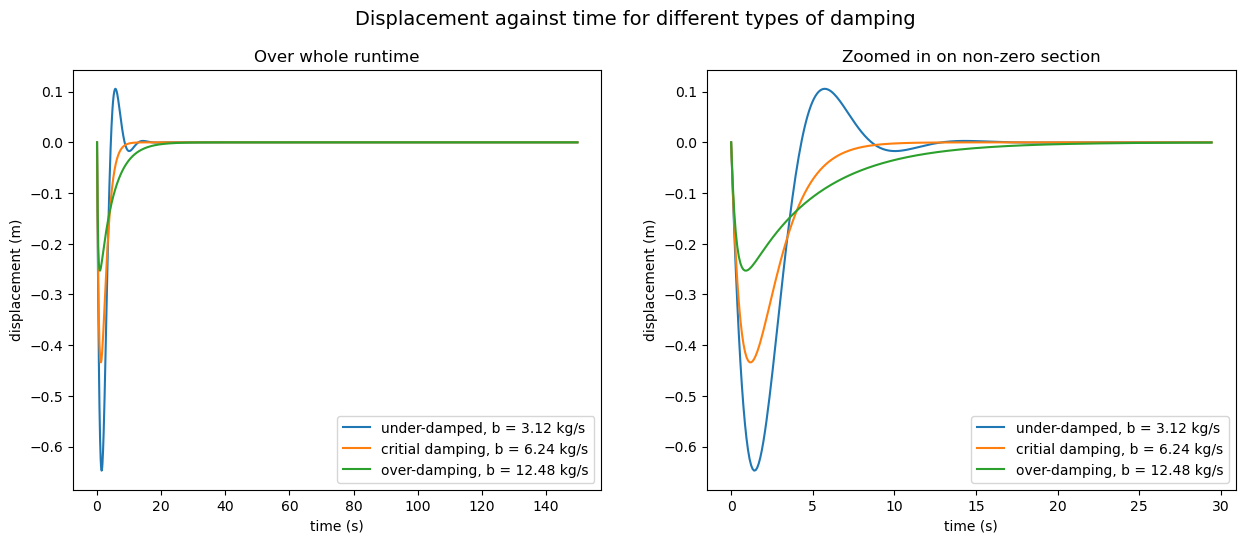

In [14]:
# Finding the values corresponding to h_final
n_steps_final, times_final = useful_conditions(h_final)

# Defining b values as above
b_under = 0.5 * b_crit
b_over = 2 * b_crit

b_trials_labels = {b_under: f'under-damped, b = {b_under:.2f} kg/s',
                   b_crit: f'critial damping, b = {b_crit:.2f} kg/s',
                   b_over: f'over-damping, b = {b_over:.2f} kg/s'}

# Finding the corresponding x and v values
x_under, v_under = verlet(n_steps_final, h_final, b_under)
x_critical, v_critical = verlet(n_steps_final, h_final, b_crit)
x_over, v_over = verlet(n_steps_final, h_final, b_over)

# Creating the figure
fig = plt.figure(figsize=(15, 12))
fig.suptitle('Displacement against time for different types of damping', fontsize=14, y=0.93)

# Plotting the results over the whole runtime
ax1 = fig.add_subplot(221)
ax1.plot(times_final, x_under, label=b_trials_labels[b_under])
ax1.plot(times_final, x_critical, label=b_trials_labels[b_crit])
ax1.plot(times_final, x_over, label=b_trials_labels[b_over])
ax1.set_xlabel('time (s)')
ax1.set_ylabel('displacement (m)')
ax1.set_title('Over whole runtime')
ax1.legend(fontsize=10)

# Finding the index of the time when the oscillations are effectively 0 (after the initial x_0)
for index, x_value in enumerate(x_over):
    x_critical_abs = np.abs(x_critical)
    x_critical_max = np.max(x_critical_abs)
    x_critical_max_index = np.where(x_critical_abs == x_critical_max)
    x_critical_max_index = x_critical_max_index[0][0]
    x_critical_max_time = times_final[x_critical_max_index]

    # Had to make sure the value being tested was after the initial few values otherwise there will be false positives
    if times_final[index] > x_critical_max_time:
        # A displacement under 1000 times less is effectively zero for plotting purposes
        if np.abs(x_value) < x_critical_max / 1000:
            cut_off_index = np.where(x_over == x_value)
            break

# Adding one to this cut of index since slices don't take the last value (ultimately makes little difference)
cut_off_index = cut_off_index[0][0] + 1

# Using slices to only plot the effectively non-zero section without recalculating everything
ax2 = fig.add_subplot(222)
ax2.plot(times_final[:cut_off_index], x_under[:cut_off_index], label=b_trials_labels[b_under])
ax2.plot(times_final[:cut_off_index], x_critical[:cut_off_index], label=b_trials_labels[b_crit])
ax2.plot(times_final[:cut_off_index], x_over[:cut_off_index], label=b_trials_labels[b_over])
ax2.set_xlabel('time (s)')
ax2.set_ylabel('displacement (m)')
ax2.set_title("Zoomed in on non-zero section")
ax2.legend(fontsize=10)

# Displaying the plot
plt.show()

# Chosen not to loop through each b value but write it manually incase the x and v values want to be use later to explore the different types of solutions.

From these graphs, it is clearly visible that under critical damping the oscillations return to equilibrium in the shortest possible time as we would expect from theory. We can also see that the amplitude of oscillations is greatest for an under-damped system and that the system comes to rest in the longest possible time when it is over-damped.

## Adding an external force

We are now ready to consider a forced system of the form: $$ m \ddot{x}(t) + b \dot{x}(t) + kx(t) = {F}(t) $$ where ${F}(t) \neq 0$. Such a differential equation only has analytical solutions for particular types of ${F}(t)$ but to study any arbitrary force a numerical method is needed, specifically we will be using Verlet's method with our best choice of $h$.

We first need to modify Verlet's method to incorporate this new force and this is done by changing the expression for the acceleration at every step. Like before we can rearrange the equation of motion but now we will include ${F}(t)$ so it reads as: $$a_{i} = -\frac{k}{m}x_{i} - \frac{b}{m}v_{i} + \frac{{F}(t)}{m} $$ which results in an extra '$+ \frac{2h^2}{2m + bh}{F}(t)$' term in the $x$ expression while $v$ stays the same (it has no dependence on $a$). The simplest way to do this is to find values of ${F}(t)$ at every timestep and input that into the iterative procedure accordingly.

In [15]:
def verlet_forced(n_steps, h, b, f_array):
    # Same initial setup as always
    x = np.zeros(n_steps)
    v = np.zeros(n_steps)
    x[0] = x_0
    v[0] = v_0

    # Using the improved euler method explicitly to get the first x value explicitly this time
    a_0 = - (k / m) * x[0] - (b / m) * v[0] + f_array[0] / m
    x[1] = x[0] + v[0] * h + 1/2 * h**2 * a_0

    # Defining some temporary constants as before
    const_d = 2 * m + b * h
    const_a = (2 / const_d) * (2 * m - k * h**2)
    const_b = (1 / const_d) * (b * h - 2 * m)

    for i in range(1, n_steps - 1):
        # Using the variation above to find the values at each step
        x[i+1] = const_a * x[i] + const_b * x[i-1] + (2 * h**2 / const_d) * f_array[i]
        v[i] = (1 / (2 * h)) * (x[i+1] - x[i-1])
        # v will still not have a term at t = T (like before)

    return x, v

# Important to note that this could've been implemented for all numerical functions at the very start by assigning an f_array of zeros if one wasn't provided. This was not done retroactively for clarification in reading the notebook front to back. This would also largely have served no purpose since we only need the best method to include an external force. The only way this could've been useful would be to treat this as the new 'analytical solution' and see how much the other methods deviate by.

We will first explore two dirac delta type forces representing instantaneous pushes and so are of the form: $$ {F}(t) = F_{0} \delta(t-t_{crit}) $$ where $F_{0}$ is the magnitude of the force applied and $t_{crit}$ is the time at which that force is applied.

The first one will be in the same direction as $v_{0}$ so $F_{0} = -50N$ and will be at $t_{crit} = 15s$ while the second will be in the opposite direction to $v_{0}$ so $F_{0} = 10N$ and will be at $t_{crit} = 45s$. The value of $b$ will be the same as the very first one trialed (under-damped) to better compare the results.

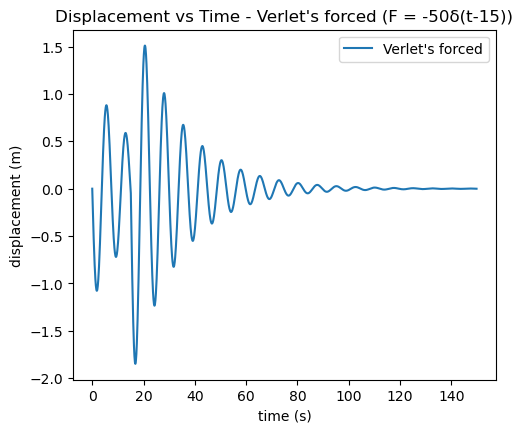

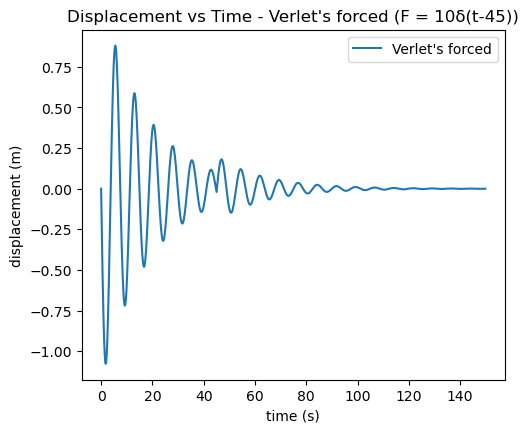

In [16]:
# Defining a force corresponding to a dirac delta function
def force_delta(n_steps, h, f_0, critical_time):
    # Creates the initial array with zeros as needed when t =/= critical time
    force = np.zeros(n_steps)

    # Find the step at which the force should be added and changes the according value in the array
    critical_step = int(critical_time / h) + 1
    force[critical_step] = f_0

    return force

# Creates dictionary of the forces that we want to test in the form 'magnitude:critical time'
forces_delta = {-50:15, 10:45}

# Uses the function to find the arrays corresponding to the two forces mentioned above
for magnitude, time in forces_delta.items():
    force_array_delta = force_delta(n_steps_final, h_final, magnitude, time)
    x_forced_delta, v_forced_delta = verlet_forced(n_steps_final, h_final, b_initial, force_array_delta)
    comparison_plot("Verlet's forced", times_final, x_forced_delta, v_forced_delta, extra_title=f'(F = {magnitude}δ(t-{time}))', phase_plot=False)

These show results we would intuitively expect, if the force is applied in the same direction as the velocity there is a sharp negative displacement and if the force is applied in the opposite direction, there is a sharp positive displacement. Both of these ultimately lead to the system taking longer to reach equilibrium.

The only effect of the dirac delta force is to change the displacement and velocity of the system momentarily giving it a push without changing any other characteristics such as the frequency of oscillation. After the push, the system resumes unforced damped oscillations as before with what are effectively new 'initial conditions' as we would expect.

We will now explore the application of a sinusoidal force of the form: $$ {F}(t) = F_{0} \sin(\omega_{f} t)$$ where $F_{0}$ is the amplitude of this periodic force and $\omega_{f}$ is the angular frequency of the external force. This is specifically differentiated it from $\omega$ that we used in the analytical solution to the unforced oscillator as there is no reason for these two to be equal.

The form of the solution will change as $\omega_{f}$ is changed particularly around $\omega_{0}$ which is the natural frequency of the oscillator which we stated when looking at the analytical solution. We will explore this variation later but for now to have an idea of what the oscillation will look like we will explore a given value of $\omega_{f} \neq \omega_{0}$ and compare it to the unforced oscillations. To do this we take $F_{0} = 2N$, $\omega_{f} = \frac{\omega_{0}}{2}$ (arbitrarily chosen) and $b$ to be the same as before to compare.

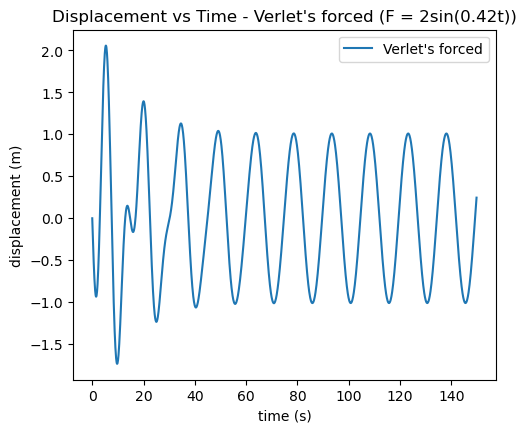

In [17]:
def force_sin(t, f_0, omega):
    # No need for a zeros array here since there is apriori no zero force at any time
    # Omega must be in rad/s as per the documentation of np.sin
    return f_0 * np.sin(omega * t)

# Allows a t array to be inputted to yield a force array output
force_sin = np.vectorize(force_sin)

# No need to have a dictionary here since we only want one value of F_0 or omega_f so they are just explicitly defined
magnitude, omega_f = 2, omega_0 / 2

# Finding the force value at every time, finding the corresponding x and v values and plotting them all
force_array_sin = force_sin(times_final, magnitude, omega_f)
x_forced_sin, v_forced_sin = verlet_forced(n_steps_final, h_final, b_initial, force_array_sin)
comparison_plot("Verlet's forced", times_final, x_forced_sin, v_forced_sin, extra_title=f'(F = {magnitude}sin({omega_f:.2f}t))', phase_plot=False)

This graph shows the characteristic response seen from a periodic external force showing 2 portions on the graph. The first part shows the transient response according to unforced oscillations at angular frequency $\omega$ as before. This is followed by a brief chaotic period before we enter into the second part which shows the steady state oscillations. Here the transient response has died and all that are left are periodic oscillations now of a different angular frequency $\omega_{f}$ mirroring the periodic force.

The form of this steady state solution can be given as: $$ x_{steady} = A_{f}e^{i\omega_{f} t} + B_{f}e^{-i \omega_{f} t} $$ where $A_{f}$ and $B_{f}$ and constants to be set (not relevant here) and are in general different to $A$ and $B$ calculated for the analytical solution earlier hence the distinction. These oscillations, which resemble unforced un-damped oscillations, continue indefinitely as long as the form of the force doesn't change.

## Exploring Resonance

As mentioned, the form of the overall solution changes drastically around $\omega_{f} = \omega_{0}$. If the system driven is near or specifically at its natural frequency, the amplitude of oscillation increases in theory indefinitely but in practice to a maximum depending on the choice of $b$. This is known as resonance and is true for any periodic force so we will use the same type as previously.

To try and find the natural frequency numerically and investigate how the amplitudes change with frequency, we will plot angular frequency, $\omega_{f}$, for a range of values against the amplitudes, ${A}(\omega_{f})$, of the steady state oscillations. To better explore the effects, we will do this for the three different values of $b$ all corresponding to very light damping as we were exploring initially as this gives the best results since the external force's effect can clearly be seen. The amplitude of the external force is of little difference and will just change the value of the peak so we will use the same value as the one before, $F_{0} = 2N$.

Analytical natural frequency is 0.843 rad/s
For b = 0.3, the natural angular frequency is given as 0.839 ± 0.009 rad/s
For b = 0.6, the natural angular frequency is given as 0.839 ± 0.009 rad/s
For b = 0.9, the natural angular frequency is given as 0.822 ± 0.009 rad/s


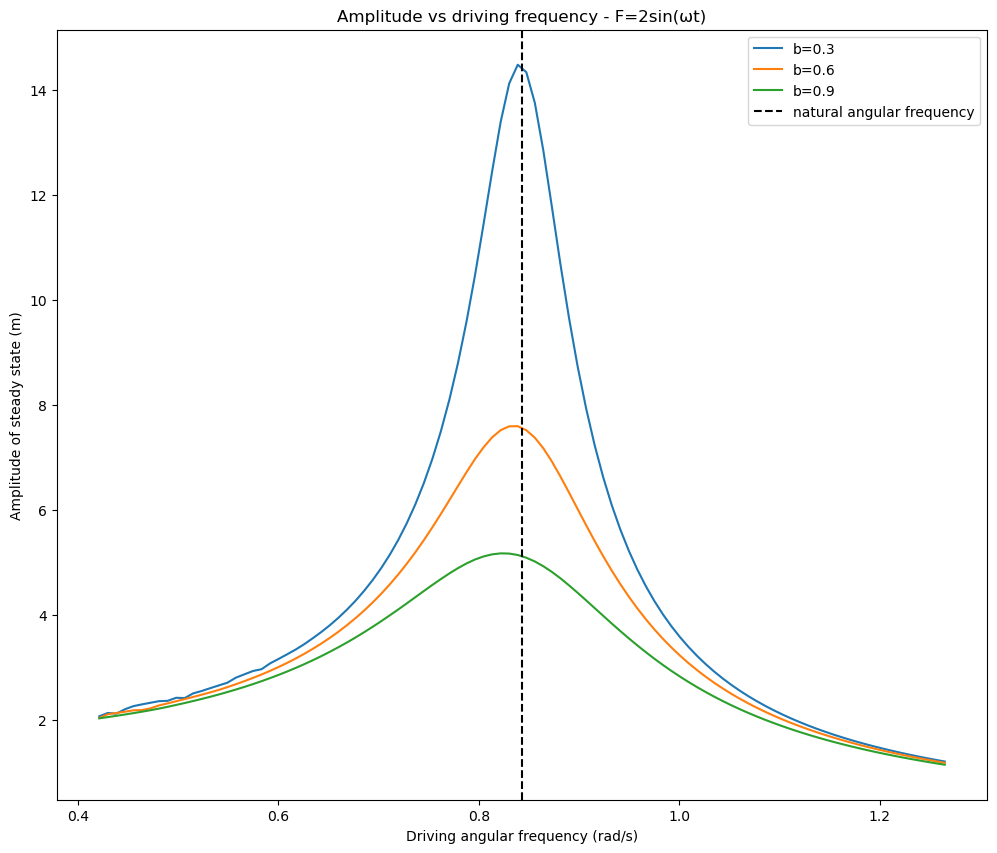

In [18]:
# Setting the values of angular frequency to be tested
omega_f_range, omega_f_range_diff = np.linspace(omega_0 / 2, omega_0 * 3 / 2, num=100, retstep=True)

T_double = 300
n_steps_final_double, times_final_double = useful_conditions(h_final, T_double)

b_trials = [0.3, 0.6, 0.9]

def find_amplitude(x_forced, n_steps):

    # Creating an empty array to store the peaks
    peaks = []

    # Finds all the peaks and troughs in using the positional data and adds the peaks to the list
    x_forced = np.abs(x_forced)
    for step in range(1, n_steps - 1):
        x_current = x_forced[step]
        if x_current > x_forced[step+1] and x_current > x_forced[step-1]:
            peaks.append(x_current)

    # Find the average of all the peaks, we are only interested in the magnitude so weather the peak was a maxima or a minima is irrelavant, more peaks gives in general better data
    peaks_average = np.mean(peaks)
    # The amplitude is twice the peak if we assume even oscillation
    amplitude = peaks_average * 2

    return amplitude

# This function does assume that there is no other force apart from the singular periodic force present (for example there could have been a push as well as a periodic force) however there is no need to generalise it in this case.
# It also averages over all amplitudes instead of just the ones corresponding to steady state oscillation. This should make little difference as we are only interested in relative amplitudes to compare and the transient response minimally changed by omega changing.

# Prints the natural frequency as predicted by theory
print(f"Analytical natural frequency is {omega_0:.3f} rad/s")

# Initialises the plot
plt.figure(figsize=(12, 10))
plt.title(f"Amplitude vs driving frequency - F={magnitude}sin(ωt)")
plt.xlabel('Driving angular frequency (rad/s)')
plt.ylabel('Amplitude of steady state (m)')

# Loops through the b values defined before when we studied different types of damping on the unforced oscillator
for b_trial in b_trials:
    # Creates an empty list to store the amplitudes for all values of angular frequency
    x_amplitudes = []

    # Loops through each omega value to find the corresponding amplitude
    for omega_f in omega_f_range:
        force_array_reso = force_sin(times_final_double, magnitude, omega_f)
        x_forced_reso, v_forced_reso = verlet_forced(n_steps_final_double, h_final, b_trial, force_array_reso)
        x_amplitude = find_amplitude(x_forced_reso, n_steps_final_double)
        x_amplitudes.append(x_amplitude)

    # Plots the data
    plt.plot(omega_f_range, x_amplitudes, label=f'b={b_trial}')

    # Find the natural frequency according our numerical method for that value of b and printing it
    numerical_omega_0_index = np.where(x_amplitudes == np.max(x_amplitudes))
    numerical_omega_0 = omega_f_range[numerical_omega_0_index][0]
    print(f"For b = {b_trial}, the natural angular frequency is given as {numerical_omega_0:.3f} ± {omega_f_range_diff:.3f} rad/s")

# Plots the natural frequency as predicted by theory
plt.axvline(omega_0, color='k', linestyle='--', label='natural angular frequency')

# Shows the legend and the plot
plt.legend(fontsize=10)
plt.show()


This plot shows what we would expect, as you get closer to the angular frequency the amplitude of oscillation increases to a maximum. The accuracy in determining $\omega_{0}$ from this is limited by the difference between subsequent $\omega_{f}$ values and we can see this as near the peak of the tallest there is a sharp horizontal line instead of a smooth curve (the figure has been made bigger so this is clearly visible). This difference can be considered to be the error on the value.

We can see that for lower values of $b$, there is much better alignment between the numerical and analytical solutions, our first 2 values are well within one $\sigma$ and the last value is within about 2$\sigma$. This is because as the damping increases, it takes longer for the transient solution to die out and it has a much higher effect on the subsequent amplitudes of the steady state solution. This is why as $b$ is increased the curves veer towards a lower frequency and flatten out. Ths is also why we considered relatively low values of $b$ much lower than $b_{crit}$ otherwise we would not have got meaningful results.

It is not done numerically here but from such values, a power resonance curve of ${A}(\omega_{f})^2$ against angular frequency, $\omega_{f}$, can be plotted to determine the damping factor, $\gamma$, from the full width half maximum. Visually we can see that as $b$ increases, numerically and analytically $\gamma$ decreases. Ultimately this can be used to find the quality factor given by $$ Q = \frac{\omega_{0}}{\gamma} = \frac{f_{0}}{f_{fwhm}} $$ where $f_{fwhm}$ is the frequency at full width half maximum. This would increase as $b$ increases showing that the quality of an oscillator, which is how many cycles are required for the energy in the system to fall by a factor of $\frac{1}{e^{2\pi}}$, increases; in other words the system loses less energy for higher values of $b$.

## Trialing another method - 4th order Runge Kutta

This is another numerical method and is very commonly used so we will also trial it here and compare the results. To that end we will return to using the equation for unforced motion, ${F}(t) = 0$, so that there is an analytical solution to compare to.

The methodology here is significantly different to the methods we have considered so far. The premise here is to solve this second order ordinary differential equation by reducing it to two first order equations of the form: $$ \frac{dx}{dt} = v $$ $$\frac{dv}{dt} = {a}(x, v) = -\frac{k}{m}x_{i} - \frac{b}{m}v_{i}$$ and taking $dx = vdt$ and $dv = {a}(x, v)dt$. For every $x_{i}$ and $v_{i}$, $dx$ and $dv$ are calculated in 4 different steps (hence the 4th order of the method) before being combined at the end and added onto $x_{i}$ and $v_{i}$ to give $x_{i+1}$ and $v_{i+1}$. Different values are given to the function ${a}(x, v)$ throughout. This is fairly tedious to write in full so the full details are left to the code below.

In [19]:
def forth_runge_kutta(n_steps, h, b):

    # Same setup as always
    x = np.zeros(n_steps)
    v = np.zeros(n_steps)
    x[0] = x_0
    v[0] = v_0

    # Defining a function for the acceleration, very useful in nicely displaying the proceeding calculations
    def acceleration(x_val, v_val):

        return - (k / m) * x_val - (b / m) * v_val

    # Using the 4th order Runge Kutta method
    for i in range(n_steps - 1):
        # Assigning the current values to better keep track of them
        x_curr, v_curr = x[i], v[i]

        # Using an iterative process to ultimately find dx and dv
        dx_1 = h * v_curr
        dv_1 = h * acceleration(x_curr, v_curr)

        dx_2 = h * (v_curr + dv_1 / 2)
        dv_2 = h * acceleration(x_curr + dx_1 / 2, v_curr + dv_1 / 2)

        dx_3 = h * (v_curr + dv_2 / 2)
        dv_3 = h * acceleration(x_curr + dx_2 / 2, v_curr + dv_2 / 2)

        dx_4 = h * (v_curr + dv_3)
        dv_4 = h * acceleration(x_curr + dx_3, v_curr + dv_3)

        dx = (dx_1 + 2 * dx_2 + 2 * dx_3 + dx_4) / 6
        dv = (dv_1 + 2 * dv_2 + 2 * dv_3 + dv_4) / 6

        # Finding the next values of x and v to loop through
        x[i+1] = x_curr + dx
        v[i+1] = v_curr + dv

    return x, v

We can compare this to the analytical solution as we did previously for all other methods using the same values we initially set for $h$ and $b$ so that it's easier to compare.

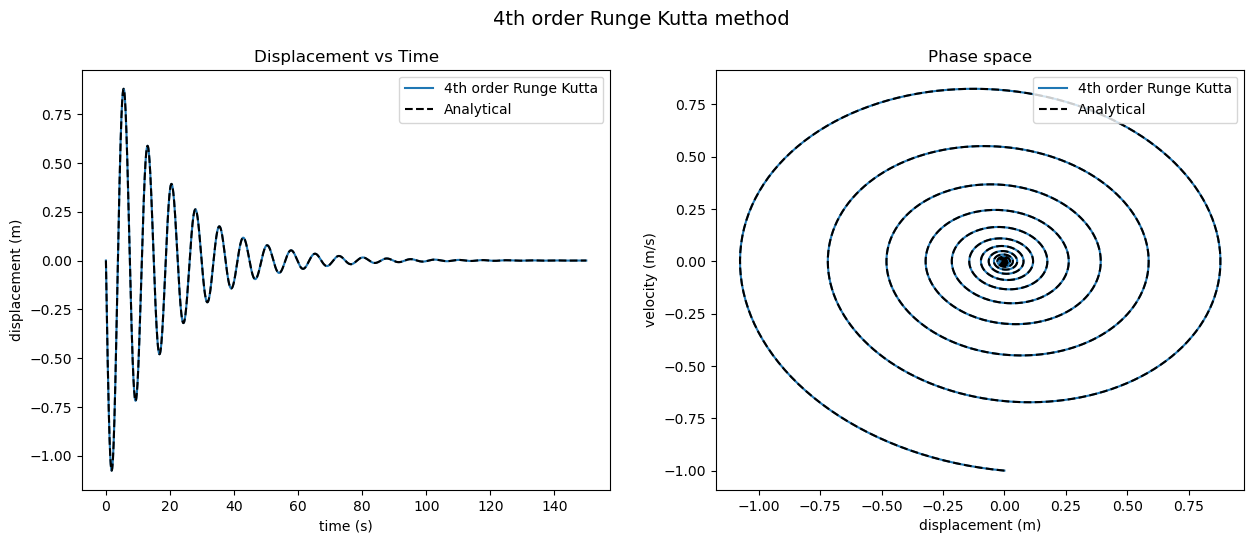

In [20]:
x_rg4, v_rg4 = forth_runge_kutta(n_steps_initial, h_initial, b_initial)

comparison_plot('4th order Runge Kutta', times_initial, x_rg4, v_rg4, x_analytic_initial, v_analytic_initial)

Visually, the 4th order Runge Kutta method and the analytical solution look identical and it is impossible to see if this is better than Verlet's method. To get an even better idea we will now look at the energy as well.

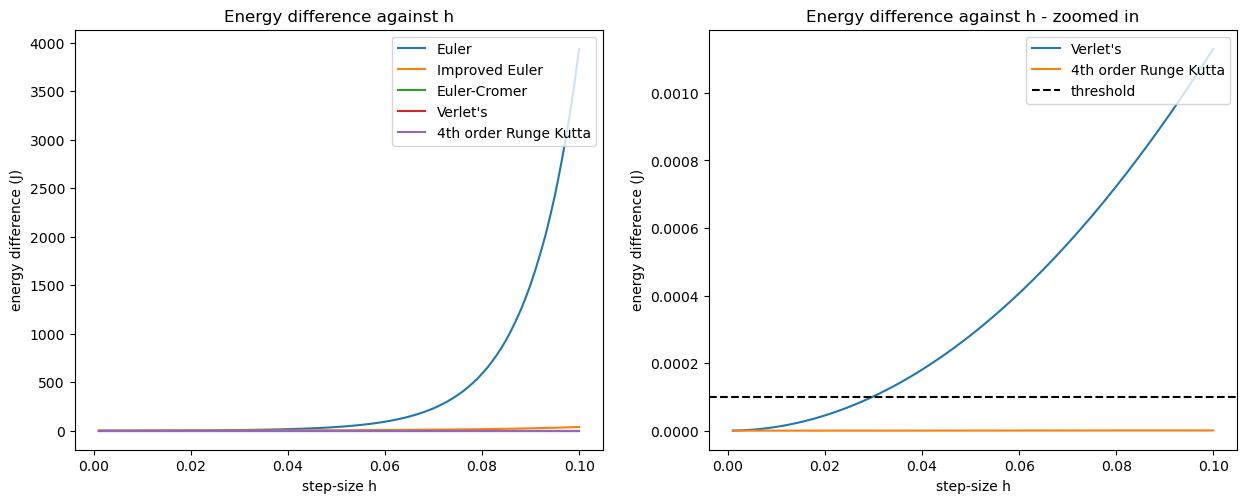

The maximum difference over this range of h values is 6.56e-07.


In [21]:
# Defines a dictionary to store the information about this additional method
additional_method = {'4th order Runge Kutta': forth_runge_kutta}

# Find the new diffs for this new method and stores them into the same dictionary
additional_energy_diffs = np.empty((0, len(additional_method)))

for h_value in h_values:
    additional_energy_diffs_temp = find_energy_diff(h_value, b_test, additional_method)
    additional_energy_diffs = np.vstack((additional_energy_diffs, additional_energy_diffs_temp))

for index, method in enumerate(additional_method.keys()):
    energy_diffs = additional_energy_diffs[:, index]
    numerical_methods_energydiffs[method] = energy_diffs

# Assigns a new much smaller threshold and plots the energy difference using it
threshold_new = 0.0001
energy_diff_plot(numerical_methods_energydiffs, threshold_new)

maximum_diff_rg4 = np.max(numerical_methods_energydiffs['4th order Runge Kutta'])
print(f"The maximum difference over this range of h values is {maximum_diff_rg4:.2e}.")

From this we can clearly see that the 4th order Runge Kutta method is not only symplectic but is still virtually indistinguishable from the analytical solution to the point where it is almost the numerical error of python! This means that it would have been a much better method to use even at relatively large values of $h$ and explains why it is one of the most prefered numerical methods of integration in the wider scientific community.